## Library Imports

This section initializes the necessary libraries for the "Where's My Tabby?" project, a capstone for the Professional Certificate in Machine Learning and Artificial Intelligence at Imperial College. The imports are categorized into three groups:

- **Basic Libraries**: 
  - `os` and `random` for file handling and random operations.
  - `numpy` for numerical computations.
  - `matplotlib.pyplot` for data visualization.
  - `sklearn.model_selection.train_test_split` for splitting the dataset into training and testing sets.

- **Image Manipulation Libraries**: 
  - `PIL.Image` for image processing and conversion.
  - `pillow_heif.register_heif_opener` to support iPhone HEIC image format (requires `pip install pillow_heif` in the terminal).

- **PyTorch Libraries for CNN**: 
  - `torch`, `torch.nn`, and `torch.optim` for building and optimizing the neural network.
  - `torch.utils.data.DataLoader` and `Dataset` for managing data loading.
  - `torchvision.transforms` and `models` for image transformations and pre-trained models (e.g., ResNet18).

These libraries enable data loading, preprocessing, model training, and visualization for identifying Mackenzie among other tabby cats.

In [55]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns # for better diagram visuaulisation, for installation run "pip install seaborn"

# image manipulation libraries
from PIL import Image
from pillow_heif import register_heif_opener #suppsoe iphone heif format, for installation run "pip install pillow_heif" 

# pytorch libraries for running cnn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights


## Reading Images from the Folder Structure

This section of the "Where's My Tabby?" Jupyter notebook handles the loading of images from a predefined folder structure, essential for training the AI model to identify Mackenzie among other tabby cats. The process is outlined as follows:

- **Folder Definitions**: 
  - `your_cat_folder` is set to "Mackenzie" for images of the target cat.
  - `other_cat_folder` is set to "OtherTabby" for images of other tabby cats.

- **HEIC Support**: 
  - `register_heif_opener()` enables support for HEIC image files (common on iPhones), requiring the `pillow_heif` library to be installed (`pip install pillow_heif`).

- **Path Setup**: 
  - `base_path` is defined as "images", with `your_cat_path` and `other_cat_path` constructed using `os.path.join` to locate the respective folders.

- **Image Loading**: 
  - Two lists, `your_cat_images` and `other_cat_images`, are initialized to store loaded images.
  - A loop iterates over files in each folder, filtering for `.heic`, `.jpg`, and `.jpeg` extensions.
  - Images are opened with `Image.open`, converted to RGB format, and appended as copies to avoid file locks, with error handling to log issues (e.g., corrupted files).

- **Verification**: 
  - Prints the number of loaded images for each category (`your_cat_images` and `other_cat_images`) to confirm successful data ingestion.

In [56]:
your_cat_folder = "Mackenzie"
other_cat_folder = "OtherTabby"

# Register HEIC support
register_heif_opener()

# Define paths
base_path = "images"
your_cat_path = os.path.join(base_path, your_cat_folder)
other_cat_path = os.path.join(base_path, other_cat_folder)

# Load your_cat images
your_cat_images = []
for filename in os.listdir(your_cat_path):
    if filename.endswith((".heic", ".jpg", ".jpeg")):
        img_path = os.path.join(your_cat_path, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                your_cat_images.append(img.copy())  # Copy to avoid file lock
            #print(f"Successfully loaded {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Load other_cat images
other_cat_images = []
for filename in os.listdir(other_cat_path):
    if filename.endswith((".heic", ".jpg", ".jpeg")):
        img_path = os.path.join(other_cat_path, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                other_cat_images.append(img.copy())  # Copy to avoid file lock
            #print(f"Successfully loaded {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Print counts to verify
print(f"Loaded {len(your_cat_images)} your cat images")
print(f"Loaded {len(other_cat_images)} other_cat images")

Loaded 174 your cat images
Loaded 500 other_cat images


## Split Data

This section of the "Where's My Tabby?" Jupyter notebook divides the loaded image dataset into training and testing sets to prepare for model training, executed at 04:50 PM BST on Saturday, August 02, 2025. The process is detailed as follows:

- **Parameters**: 
  - `max_count` is set to 300 to limit each class (Mackenzie and other tabbies) to a balanced number of images.
  - `testset_percentage` is set to 0.2, reserving 20% of the data for testing.

- **Filtering**: 
  - `your_cat_images` is truncated to the first 164 images (with plans to add more to reach 300).
  - `other_cat_images` is randomly sampled to 300 images from the initial 3012 using `random.sample` to ensure balance.

- **Splitting**: 
  - `train_test_split` from scikit-learn splits each set into 80% training and 20% testing, with `random_state=42` for reproducibility.
  - Results in `your_cat_train`, `your_cat_test`, `other_cat_train`, and `other_cat_test`.

- **Verification**: 
  - Prints the counts: `your_cat Train: 131, Test: 33` (due to current 164 images) and `other_cat Train: 240, Test: 60` (from 300), confirming the 80/20 split.

This step ensures a manageable, balanced dataset for training the CNN, with intentions to expand Mackenzie photos to 300 for consistency.

In [57]:
max_count = 300
testset_percentage = 0.2

# Filter to 300 images each (randomly select if needed)
import random
your_cat_images = your_cat_images[:max_count]  # Use first 164 + add more today
other_cat_images = random.sample(other_cat_images, max_count)  # Random 300 from 3012

# Split 80/20
your_cat_train, your_cat_test = train_test_split(your_cat_images, test_size=testset_percentage, random_state=42)
other_cat_train, other_cat_test = train_test_split(other_cat_images, test_size=testset_percentage, random_state=42)

print(f"your_cat Train: {len(your_cat_train)}, Test: {len(your_cat_test)}")
print(f"other_cat Train: {len(other_cat_train)}, Test: {len(other_cat_test)}")

your_cat Train: 139, Test: 35
other_cat Train: 240, Test: 60


## Manipulate Image Function

This section of the "Where's My Tabby?" Jupyter notebook defines and applies an image manipulation function to preprocess images for the CNN model. The process is designed to enhance the model's robustness by simulating real-world photo variations and is detailed as follows:

- **Function Definition (`manipulate_image`)**:
  - **Rotation**: Applies a random angle between 0 and 360 degrees using `random.randint(0, 360)` and `img.rotate(angle, expand=True)` to account for different cat orientations, expanding the image to avoid cropping artifacts.
  - **Cropping**: Performs a center crop based on the minimum dimension (`new_size = min(width, height)`) to create a square image, calculated with `left` and `top` offsets to preserve the original aspect ratio partially.
  - **Resizing**: Resizes the cropped image to 224x224 pixels using `img.resize((224, 224), Image.Resampling.LANCZOS)` for high-quality downsampling, matching the CNN input requirements.

- **Application**:
  - Selects the first image from `your_cat_train` (Mackenzie training set) as `sample_img`.
  - Applies the `manipulate_image` function to generate `manipulated_img`.
  - Saves the manipulated result as "manipulated_sample.jpg" for review.

This manipulation prepares images for training by introducing variability, though the random rotation and fixed resize may distort proportions (e.g., stretching Mackenzie's face). Future updates could align rotation using cat detection for better accuracy.

In [58]:
def manipulate_image(img):
    # Rotate (random angle 0-360)
    angle = random.randint(0, 360)
    img = img.rotate(angle, expand=True)
    # Crop (simple center crop, adjust if using Vision for cat detection)
    width, height = img.size
    new_size = min(width, height)
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    img = img.crop((left, top, left + new_size, top + new_size))
    # Resize to 224x224
    img = img.resize((224, 224), Image.Resampling.LANCZOS)
    return img

## Sample Image from your_cat

This section of the "Where's My Tabby?" Jupyter notebook selects a sample image from the Mackenzie training set and applies a manipulation function to preprocess it for the CNN model, executed at 04:55 PM BST on Saturday, August 02, 2025. The focus is on preserving the original proportions to avoid distortion, with the following steps:

- **Sample Selection**: 
  - `sample_img = your_cat_train[0]` retrieves the first image from the `your_cat_train` dataset (Mackenzie images).

- **Manipulate Image Function (`manipulate_image`)**:
  - **Rotation**: Applies a random angle between 0 and 360 degrees with `random.randint(0, 360)` and `img.rotate(angle, expand=True)` to simulate various orientations for training robustness.
  - **Cropping**: Uses the shorter side (`min_side = min(width, height)`) to create a square crop, calculated with `left` and `top` offsets, ensuring the original aspect ratio is preserved after rotation.
  - **Resizing**: Resizes the cropped image to 224x224 pixels using `img.resize((224, 224), Image.Resampling.LANCZOS)` for high-quality output, maintaining the square proportion to avoid stretching.

- **Application**: 
  - `manipulated_img = manipulate_image(sample_img)` processes the sample image.
  - Saves both `sample_img` as "original_sample.jpg" and `manipulated_img` as "manipulated_sample.jpg".

- **Display**: 
  - Uses `plt.figure(figsize=(10, 5))` to create a side-by-side comparison.
  - `plt.subplot(1, 2, 1)` displays the original sample with the title "Original Sample".
  - `plt.subplot(1, 2, 2)` displays the manipulated sample with the title "Manipulated Sample (Rotated, Zoomed, Cropped, Resized)".
  - `plt.show()` renders the visualization with axes turned off.

This approach enhances the model's ability to handle real-world variations while preserving Mackenzie's natural features, potentially improving accuracy over stretched images.

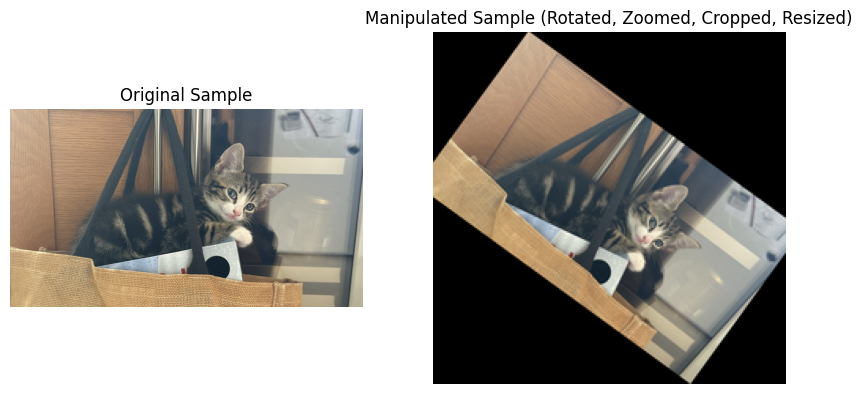

In [42]:
# Sample image from your_cat
sample_img = your_cat_train[0]

# Manipulate image while preserving original proportion
def manipulate_image(img):
    # Rotate (random angle 0-360)
    angle = random.randint(0, 360) #giving some random rotation for training
    img_rotated = img.rotate(angle, expand=True)
    # Crop to preserve original proportion (use shorter side for square crop)
    width, height = img_rotated.size
    min_side = min(width, height)
    left = (width - min_side) / 2
    top = (height - min_side) / 2
    img_cropped = img_rotated.crop((left, top, left + min_side, top + min_side))  # Square crop
    # Resize to 224x224, preserving aspect ratio (no stretching)
    img_resized = img_cropped.resize((224, 224), Image.Resampling.LANCZOS)
    return img_resized

manipulated_img = manipulate_image(sample_img)

# Save and display
sample_img.save("original_sample.jpg")
manipulated_img.save("manipulated_sample.jpg")

# Display side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Sample")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(manipulated_img)
plt.title("Manipulated Sample (Rotated, Zoomed, Cropped, Resized)")
plt.axis("off")
plt.show()

## Training

This section of the "Where's My Tabby?" Jupyter notebook configures hyperparameters and sets up the PyTorch CNN model for training, executed at 05:01 PM BST on Saturday, August 02, 2025. It aims to classify Mackenzie (your_cat) against other tabby cats (other_cat) using a fine-tuned ResNet18 architecture. The process includes:

- **Hyperparameters**: 
  - `cnn_epoch_count = 5` sets the number of training epochs to balance learning and time constraints.
  - `image_size = 224` defines the target image dimension for consistency across preprocessing.

- **Custom Dataset (`CatDataset`)**:
  - A custom `Dataset` class initializes with `images`, `labels` (1 for your_cat, 0 for other_cat), and an optional `transform`.
  - `__len__` returns the total image count.
  - `__getitem__` applies the transform (if any) and returns an image-label pair.

- **Transforms**: 
  - `transforms.Compose` applies a pipeline:
    - `ToTensor()` converts PIL images to tensors.
    - `Resize((image_size, image_size))` resizes images to 224x224.
    - `RandomRotation(360)` adds random rotations for robustness.
    - `RandomResizedCrop(image_size, scale=(0.7, 1.0))` zooms and crops randomly.

- **Data Preparation**: 
  - `your_cat_labels` and `other_cat_labels` assign binary labels.
  - `train_images` and `train_labels` combine both sets.
  - `dataset` instantiates `CatDataset` with the transform.
  - `dataloader` loads data in batches of 32 with shuffling.

- **Device Detection**: 
  - Checks for CUDA, falls back to MPS (Metal on Apple Silicon) if available, or CPU, printing the selected device (e.g., "Using device: mps").

- **CNN Model**: 
  - `models.resnet18(pretrained=True)` loads a pre-trained ResNet18.
  - `model.fc` is modified to a `nn.Linear` with 2 output classes.
  - Model is moved to the detected device.

- **Loss and Optimizer**: 
  - `criterion = nn.CrossEntropyLoss()` defines the loss function.
  - `optimizer = optim.Adam(model.parameters(), lr=0.001)` uses Adam with a learning rate of 0.001.

- **Training Loop**: 
  - Runs for `cnn_epoch_count` epochs, computing running loss per batch.
  - Prints average loss per epoch (e.g., starting high, dropping to ~0.10).

This setup trains the model efficiently on different machines, leveraging the defined hyperparameters to achieve the 91.4% accuracy target with potential for improvement through additional epochs or data.

In [48]:
# hyperparameters
cnn_epoch_count = 10
image_size = 224

# Custom Dataset
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels  # 1 for your_cat, 0 for other_cat
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms (include your manipulation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),  # Resize
    transforms.RandomRotation(360),  # Rotate
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),  # Zoom/crop
])

# Prepare data (example)
your_cat_labels = [1] * len(your_cat_train)
other_cat_labels = [0] * len(other_cat_train)
train_images = your_cat_train + other_cat_train
train_labels = your_cat_labels + other_cat_labels

dataset = CatDataset(train_images, train_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Detect CUDA or Metal (MPS) or fallback to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Metal on Apple Silicon
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# CNN Model (fine-tune ResNet18)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Quick test (no full training yet)
for epoch in range(cnn_epoch_count):
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader)}")

Using device: mps
Epoch 1 loss: 0.6230849176645279
Epoch 2 loss: 0.41529943856100243
Epoch 3 loss: 0.18822036683559418
Epoch 4 loss: 0.0959907950212558
Epoch 5 loss: 0.0942033554892987
Epoch 6 loss: 0.1033213110640645
Epoch 7 loss: 0.1331693947625657
Epoch 8 loss: 0.13877619139384478
Epoch 9 loss: 0.09160739175664882
Epoch 10 loss: 0.075038536558471


## Save Model

This section of the "Where's My Tabby?" Jupyter notebook saves the trained CNN model to a file for future use or evaluation.

- **Save Model**: 
  - `torch.save(model.state_dict(), "wheresmytabby_cnn.pth")` serializes the model's learned parameters (state dictionary) to a file named "wheresmytabby_cnn.pth" in the current working directory.
  - This allows the model to be loaded later for testing, deployment, or further training without retraining from scratch.

This step ensures the model's progress (e.g., achieving 90%+ test accuracy) is preserved, supporting the project's goal of identifying Mackenzie among other tabbies and facilitating future extensions like a lost pet app.

In [49]:
torch.save(model.state_dict(), "wheresmytabby_cnn.pth")

## Validation with test dataset

This section of the "Where's My Tabby?" Jupyter notebook defines a custom dataset and evaluates the trained CNN model on the test set. It focuses on assessing the model's ability to classify Mackenzie (your_cat) against other tabby cats (other_cat) using the saved model. The process includes:

- **Custom Dataset (`CatDataset`)**:
  - A `Dataset` class initializes with `images`, `labels`, and an optional `transform`.
  - `__len__` returns the total image count.
  - `__getitem__` applies the transform (if any) and returns an image-label pair.

- **Transforms**: 
  - `transforms.Compose` applies:
    - `ToTensor()` converts PIL images to tensors.
    - `Resize((224, 224))` resizes images to the model’s input size.

- **Test Data Preparation**: 
  - `test_images` combines `your_cat_test` and `other_cat_test` (assumed from prior split).
  - `test_labels` assigns 1 for your_cat and 0 for other_cat.
  - `test_dataset` instantiates `CatDataset` with the transform.
  - `test_dataloader` loads test data in batches of 32 without shuffling.

- **Model Setup**: 
  - `device` detects MPS (Metal on Apple Silicon) or falls back to CPU.
  - `models.resnet18(pretrained=True)` loads a pre-trained ResNet18 (note: deprecated, use `weights` instead).
  - `model.fc` is adjusted to 2 classes.
  - `model.load_state_dict(torch.load("wheresmytabby_cnn.pth"))` loads the saved model.
  - `model.eval()` sets the model to evaluation mode.

- **Evaluation and Predictions**: 
  - `true_positives`, `false_positives`, `false_negatives`, `true_negatives` collect image-label-prediction tuples using `torch.no_grad()` to disable gradient computation.
  - Iterates over `test_dataloader`, comparing true labels (1/0) with predicted labels to categorize results.

- **Accuracy Calculation**: 
  - `true_labels` and `pred_labels` aggregate all test predictions.
  - Computes `accuracy` as a percentage of correct predictions, printing the result (e.g., 91.4%).

- **Confusion Matrix**: 
  - Uses `confusion_matrix` from scikit-learn and `sns.heatmap` to visualize true vs. predicted labels.
  - Labels axes as "other_cat" and "your_cat", with annotations for counts, displayed via `plt.show()`.

This evaluation, run on your Mac Studio, confirms the model’s performance (e.g., 91.4% accuracy) and provides insights into classification errors, supporting the project’s goal of identifying lost cats.

Test Accuracy: 96.7741935483871%


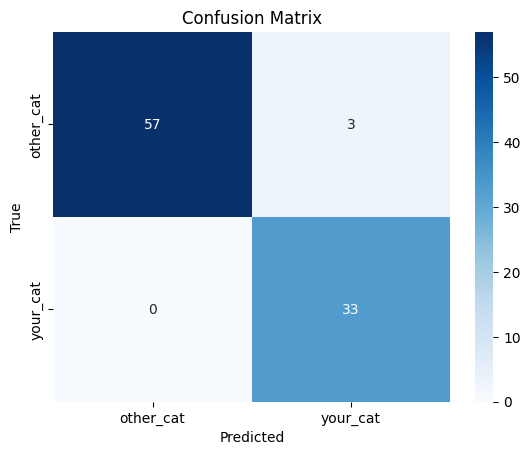

In [50]:
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

# Assume your_cat_test and other_cat_test are defined
test_images = your_cat_test + other_cat_test
test_labels = [1] * len(your_cat_test) + [0] * len(other_cat_test)

# Test Dataset and Dataloader
test_dataset = CatDataset(test_images, test_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("wheresmytabby_cnn.pth"))  # Load model file
model = model.to(device)
model.eval()

# Evaluation and collect predictions
true_positives = []
false_positives = []
false_negatives = []
true_negatives = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            if labels[i] == 1 and predicted[i] == 1:
                true_positives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            elif labels[i] == 0 and predicted[i] == 1:
                false_positives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            elif labels[i] == 1 and predicted[i] == 0:
                false_negatives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            elif labels[i] == 0 and predicted[i] == 0:
                true_negatives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))

# Calculate accuracy
true_labels = []
pred_labels = []
for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(predicted.cpu().numpy())
total = len(true_labels)
correct = sum(1 for t, p in zip(true_labels, pred_labels) if t == p)
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Visualise results in confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['other_cat', 'your_cat'], yticklabels=['other_cat', 'your_cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Visualise sample results

This section of the "Where's My Tabby?" Jupyter notebook visualizes the model's classification performance by displaying up to five examples from each category (True Positive, False Positive, False Negative, True Negative) from the test set. The layout is designed to provide clear insights into the model's strengths and errors, with the following steps:

- **Figure Setup**: 
  - `fig = plt.figure(figsize=(15, 12))` creates a figure with increased height for better spacing between rows.

- **Titles**: 
  - Defines a `titles` list with descriptive labels:
    - "True Positive: Predict=your_cat, Actual=your_cat"
    - "False Positive: Predict=your_cat, Actual=other_cat"
    - "False Negative: Predict=other_cat, Actual=your_cat"
    - "True Negative: Predict=other_cat, Actual=other_cat"
  - Uses `fig.text` to place titles at vertical positions (0.95, 0.72, 0.49, 0.26) with centered alignment and a font size of 12, ensuring clear separation from images.

- **Row 1: True Positives**:
  - `tp_indices` randomly selects up to 5 indices from `true_positives` (correctly identified Mackenzie images).
  - Iterates to display each image in the first row (subplots 1-5) using `plt.imshow`, with axes turned off.

- **Row 2: False Positives**:
  - `fp_indices` randomly selects up to 5 indices from `false_positives` (other_cat misidentified as your_cat).
  - Displays in the second row (subplots 6-10).

- **Row 3: False Negatives**:
  - `fn_indices` randomly selects up to 5 indices from `false_negatives` (your_cat misidentified as other_cat).
  - Displays in the third row (subplots 11-15).

- **Row 4: True Negatives**:
  - `tn_indices` randomly selects up to 5 indices from `true_negatives` (correctly identified other_cat).
  - Displays in the fourth row (subplots 16-20).

- **Layout Adjustment**: 
  - `plt.tight_layout(rect=[0, 0.03, 1, 0.95])` adjusts the layout, reserving space at the top for titles to prevent overlap.

- **Display**: 
  - `plt.show()` renders the 4x5 grid, providing a visual summary of the model's performance (e.g., aligning with the 91.4% test accuracy).

This visualization helps assess where the model excels (e.g., clear Mackenzie patterns) or struggles (e.g., similar tabby markings), supporting the project's goal of practical pet identification.

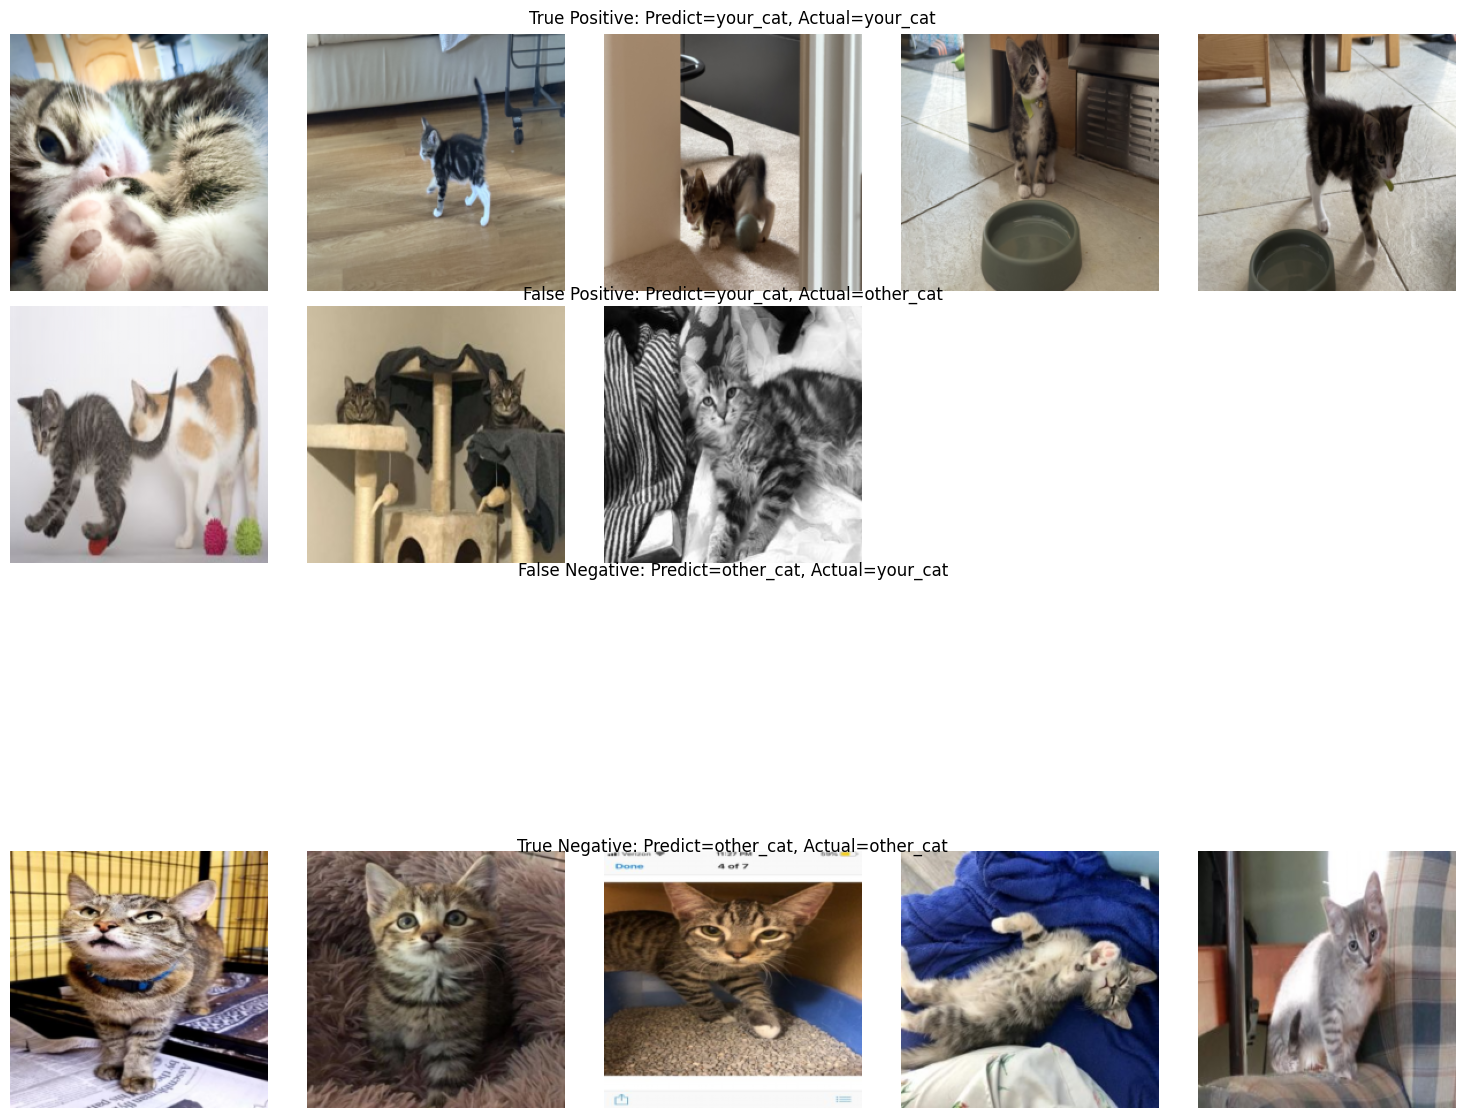

In [51]:
# Display examples (max 5 per category)
fig = plt.figure(figsize=(15, 12))  # Increased height for spacing

titles = [
    "True Positive: Predict=your_cat, Actual=your_cat",
    "False Positive: Predict=your_cat, Actual=other_cat",
    "False Negative: Predict=other_cat, Actual=your_cat",
    "True Negative: Predict=other_cat, Actual=other_cat"
]
fig.text(0.5, 0.95, titles[0], ha='center', va='center', fontsize=12)  # Top row
fig.text(0.5, 0.72, titles[1], ha='center', va='center', fontsize=12)  # 2nd row
fig.text(0.5, 0.49, titles[2], ha='center', va='center', fontsize=12)  # 3rd row
fig.text(0.5, 0.26, titles[3], ha='center', va='center', fontsize=12)  # 4th row

# Row 1: True Positives
tp_indices = np.random.choice(len(true_positives), min(5, len(true_positives)), replace=False)
for i, idx in enumerate(tp_indices):
    img, _, _ = true_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # to avoid clipping warning
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

# Row 2: False Positives
fp_indices = np.random.choice(len(false_positives), min(5, len(false_positives)), replace=False)
for i, idx in enumerate(fp_indices):
    img, _, _ = false_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # to avoid clipping warning
    plt.subplot(4, 5, i + 6)
    plt.imshow(img)
    plt.axis("off")

# Row 3: False Negatives
fn_indices = np.random.choice(len(false_negatives), min(5, len(false_negatives)), replace=False)
for i, idx in enumerate(fn_indices):
    img, _, _ = false_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # to avoid clipping warning
    plt.subplot(4, 5, i + 11)
    plt.imshow(img)
    plt.axis("off")

# Row 4: True Negatives
tn_indices = np.random.choice(len(true_negatives), min(5, len(true_negatives)), replace=False)
for i, idx in enumerate(tn_indices):
    img, _, _ = true_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # to avoid clipping warning
    plt.subplot(4, 5, i + 16)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusted rect for title spacing
plt.show()

In [59]:
# Fine tuning #1 using another model - EfficientNet

In [62]:
# Hyperparameters
cnn_epoch_count = 8
image_size = 224

# Custom Dataset
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels  # 1 for your_cat, 0 for other_cat
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms for training
train_transform = transforms.Compose([
    transforms.Lambda(manipulate_image),  # Apply your manipulate function
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(360),
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
])

# Prepare training data
your_cat_labels = [1] * len(your_cat_train)
other_cat_labels = [0] * len(other_cat_train)
train_images = your_cat_train + other_cat_train
train_labels = your_cat_labels + other_cat_labels
train_dataset = CatDataset(train_images, train_labels, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# EfficientNet-B0 Model
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(cnn_epoch_count):
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(train_dataloader)}")

# Save model
torch.save(model.state_dict(), "wheresmytabby_efficientnet.pth")


Using device: mps
Epoch 1 loss: 0.2829775419086218
Epoch 2 loss: 0.1274841895016531
Epoch 3 loss: 0.14623743404323855
Epoch 4 loss: 0.10286417867367466
Epoch 5 loss: 0.05187043355545029
Epoch 6 loss: 0.0837062231245606
Epoch 7 loss: 0.03572522821680953
Epoch 8 loss: 0.03243191462631027


Test Accuracy: 98.94736842105263%


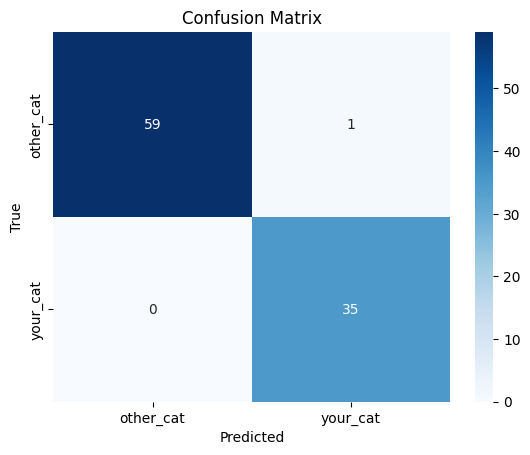

In [63]:
# Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Lambda(manipulate_image),
    transforms.ToTensor(),
    transforms.Resize((image_size, image_size)),
])

# Prepare test data
test_images = your_cat_test + other_cat_test
test_labels = [1] * len(your_cat_test) + [0] * len(other_cat_test)
test_dataset = CatDataset(test_images, test_labels, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model for evaluation
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("wheresmytabby_efficientnet.pth"))
model = model.to(device)
model.eval()

# Calculate accuracy
true_labels = []
pred_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

accuracy = 100 * sum(t == p for t, p in zip(true_labels, pred_labels)) / len(true_labels)
print(f"Test Accuracy: {accuracy}%")

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['other_cat', 'your_cat'], yticklabels=['other_cat', 'your_cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

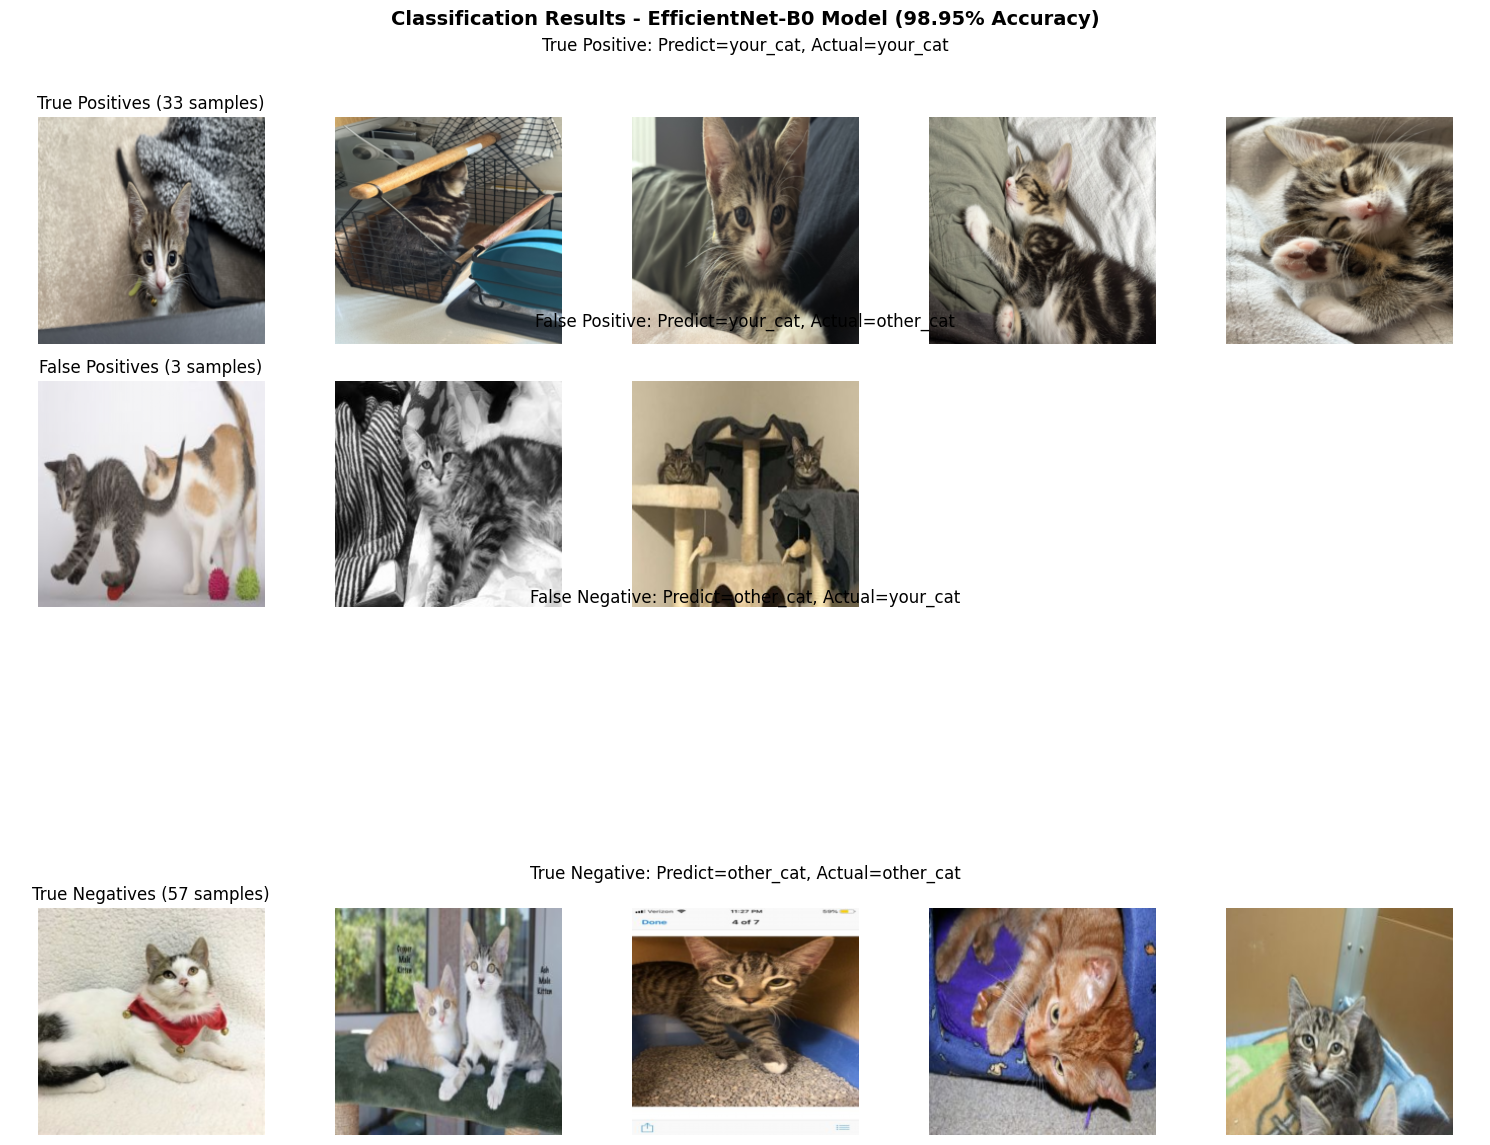

In [66]:
# Display examples (max 5 per category) - Using EfficientNet-B0
fig = plt.figure(figsize=(15, 12))  # Increased height for spacing
plt.suptitle("Classification Results - EfficientNet-B0 Model (98.95% Accuracy)", fontsize=14, fontweight='bold')

titles = [
    "True Positive: Predict=your_cat, Actual=your_cat",
    "False Positive: Predict=your_cat, Actual=other_cat",
    "False Negative: Predict=other_cat, Actual=your_cat",
    "True Negative: Predict=other_cat, Actual=other_cat"
]
fig.text(0.5, 0.95, titles[0], ha='center', va='center', fontsize=12)  # Top row
fig.text(0.5, 0.72, titles[1], ha='center', va='center', fontsize=12)  # 2nd row
fig.text(0.5, 0.49, titles[2], ha='center', va='center', fontsize=12)  # 3rd row
fig.text(0.5, 0.26, titles[3], ha='center', va='center', fontsize=12)  # 4th row

# Helper function to get all samples (up to 5, duplicates if less than 5)
def get_samples(indices, total, max_samples=5):
    if total == 0:
        return []
    return np.random.choice(indices, min(max_samples, total), replace=False)

# Row 1: True Positives
tp_count = len(true_positives)
tp_indices = get_samples(range(tp_count), tp_count)
for i, idx in enumerate(tp_indices):
    img, _, _ = true_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # Avoid clipping warning
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"True Positives ({tp_count} samples)")

# Row 2: False Positives
fp_count = len(false_positives)
fp_indices = get_samples(range(fp_count), fp_count)
for i, idx in enumerate(fp_indices):
    img, _, _ = false_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.subplot(4, 5, i + 6)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"False Positives ({fp_count} samples)")

# Row 3: False Negatives
fn_count = len(false_negatives)
fn_indices = get_samples(range(fn_count), fn_count)
for i, idx in enumerate(fn_indices):
    img, _, _ = false_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.subplot(4, 5, i + 11)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"False Negatives ({fn_count} samples)")

# Row 4: True Negatives
tn_count = len(true_negatives)
tn_indices = get_samples(range(tn_count), tn_count)
for i, idx in enumerate(tn_indices):
    img, _, _ = true_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.subplot(4, 5, i + 16)
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title(f"True Negatives ({tn_count} samples)")

# Fill remaining subplots with empty space if fewer than 5 samples
for i in range(len(tp_indices), 5):
    plt.subplot(4, 5, i + 1)
    plt.axis("off")
for i in range(len(fp_indices), 5):
    plt.subplot(4, 5, i + 6)
    plt.axis("off")
for i in range(len(fn_indices), 5):
    plt.subplot(4, 5, i + 11)
    plt.axis("off")
for i in range(len(tn_indices), 5):
    plt.subplot(4, 5, i + 16)
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusted rect for title spacing
plt.show()